# SpaceX Falcon 9 First Stage Landing Prediction

## Project Overview

This notebook builds and evaluates machine learning models to predict Falcon 9 first stage landing success. By accurately predicting landing outcomes, we can estimate launch costs and provide competitive intelligence for alternate launch providers.

### Business Context

- **SpaceX Launch Cost**: $62 million (with first stage reuse)
- **Competitor Launch Cost**: $165+ million
- **Cost Advantage**: First stage reusability
- **Prediction Value**: Estimate actual launch costs for competitive bidding

### Approach
1. Load and prepare data
2. Handle class imbalance with SMOTE
3. Train and tune multiple models
4. Evaluate and compare performance
5. Select best model for deployment

## 1. Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

print("✓ Environment configured")

✓ Environment configured


## 2. Load Data

In [2]:
df = pd.read_csv('spacex_falcon9_features.csv')

X = df.drop('Class', axis=1)
y = df['Class']

print(f"Dataset: {df.shape[0]} samples, {df.shape[1]-1} features")
print(f"\nClass Distribution:")
print(f"  Success: {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")
print(f"  Failure: {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"  Imbalance Ratio: {(y==1).sum()/(y==0).sum():.2f}:1")

Dataset: 168 samples, 85 features

Class Distribution:
  Success: 137 (81.5%)
  Failure: 31 (18.5%)
  Imbalance Ratio: 4.42:1


## 3. Train-Test Split & Preprocessing

In [3]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(y_train_balanced)} samples (balanced)")
print(f"Test: {len(y_test)} samples (original distribution)")

Training: 218 samples (balanced)
Test: 34 samples (original distribution)


## 4. Model Training & Hyperparameter Tuning

In [4]:
# Define models and hyperparameter grids
models_config = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1,2]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'criterion': ['gini', 'entropy']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

# Train models with grid search
trained_models = {}

for name, config in models_config.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train_balanced)
    trained_models[name] = grid_search.best_estimator_
    print(f"  Best CV F1: {grid_search.best_score_:.4f}")

print("\n✓ All models trained")

Training Logistic Regression...
  Best CV F1: 0.9517
Training SVM...
  Best CV F1: 0.9765
Training KNN...
  Best CV F1: 0.9405
Training Decision Tree...
  Best CV F1: 0.9392
Training Random Forest...
  Best CV F1: 0.9574
Training Gradient Boosting...
  Best CV F1: 0.9348
Training XGBoost...
  Best CV F1: 0.7686

✓ All models trained


## 5. Model Evaluation

In [5]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }, y_pred, y_proba

# Evaluate all models
results = []
predictions = {}

for name, model in trained_models.items():
    metrics, y_pred, y_proba = evaluate_model(model, X_test_scaled, y_test)
    metrics['Model'] = name
    results.append(metrics)
    predictions[name] = (y_pred, y_proba)

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            XGBoost  0.941176   0.933333 1.000000  0.965517 0.982143
  Gradient Boosting  0.911765   0.962963 0.928571  0.945455 0.937500
      Decision Tree  0.882353   0.928571 0.928571  0.928571 0.723214
      Random Forest  0.882353   0.961538 0.892857  0.925926 0.886905
Logistic Regression  0.794118   0.862069 0.892857  0.877193 0.857143
                KNN  0.794118   0.888889 0.857143  0.872727 0.678571
                SVM  0.794118   0.920000 0.821429  0.867925 0.863095


## 6. Visualizations

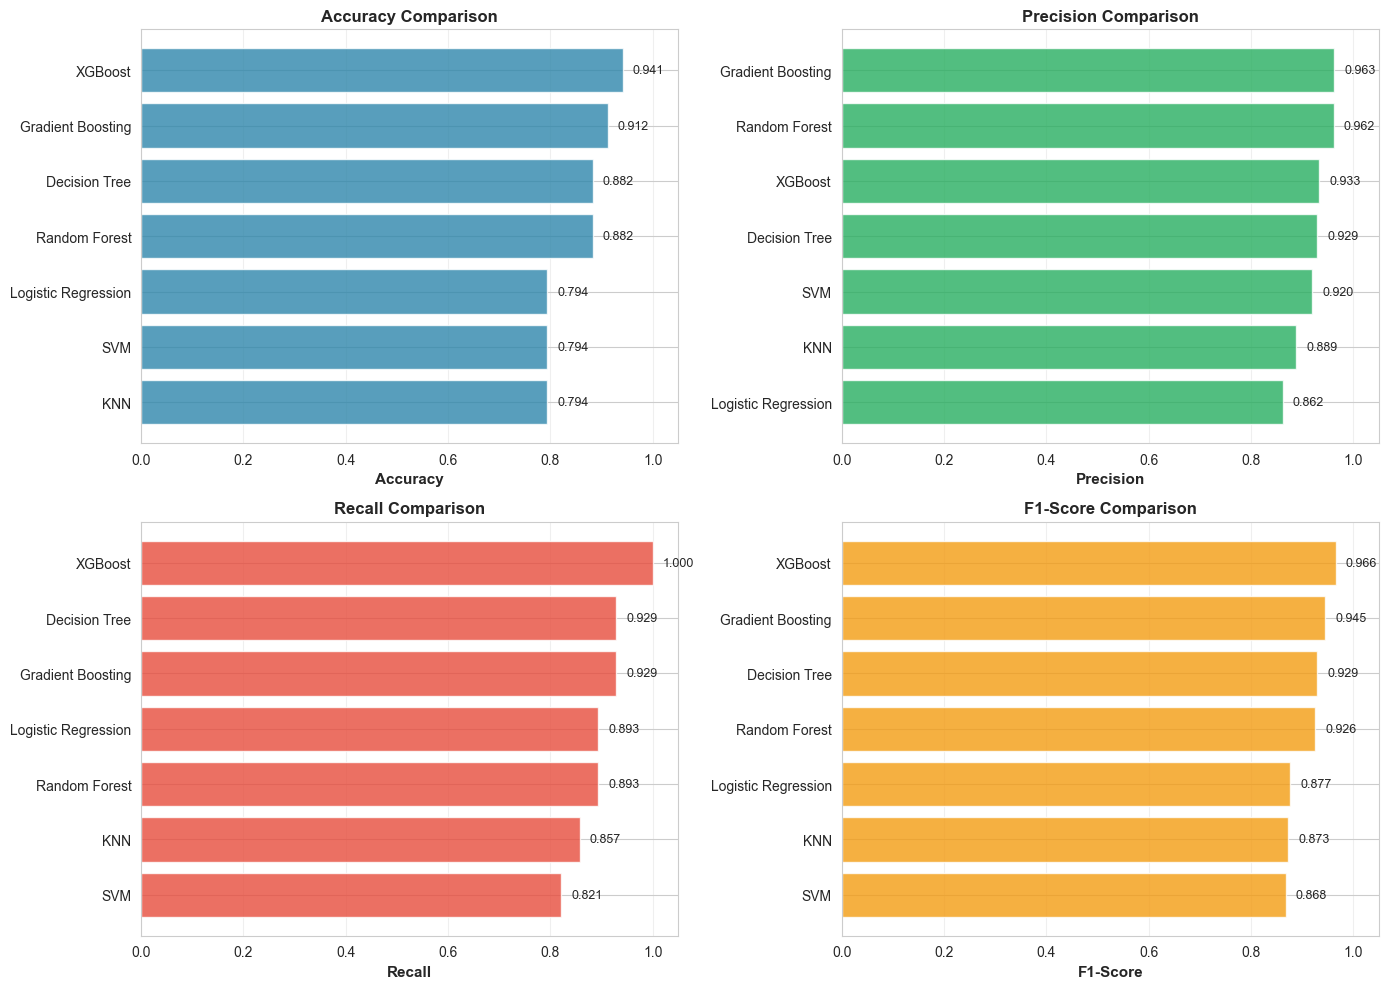

In [6]:
# Performance comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2E86AB', '#27AE60', '#E74C3C', '#F39C12']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx//2, idx%2]
    data = results_df.sort_values(metric, ascending=True)
    
    bars = ax.barh(data['Model'], data[metric], color=colors[idx], alpha=0.8)
    ax.set_xlabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1.05)
    ax.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

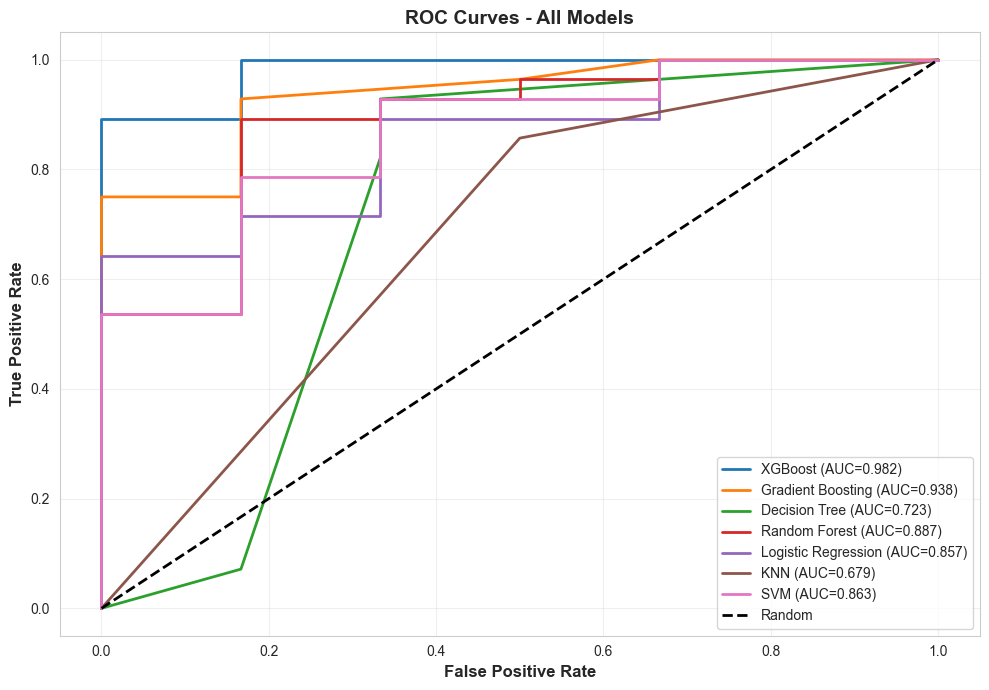

In [7]:
# ROC Curves
plt.figure(figsize=(10, 7))

for name in results_df['Model']:
    _, y_proba = predictions[name]
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

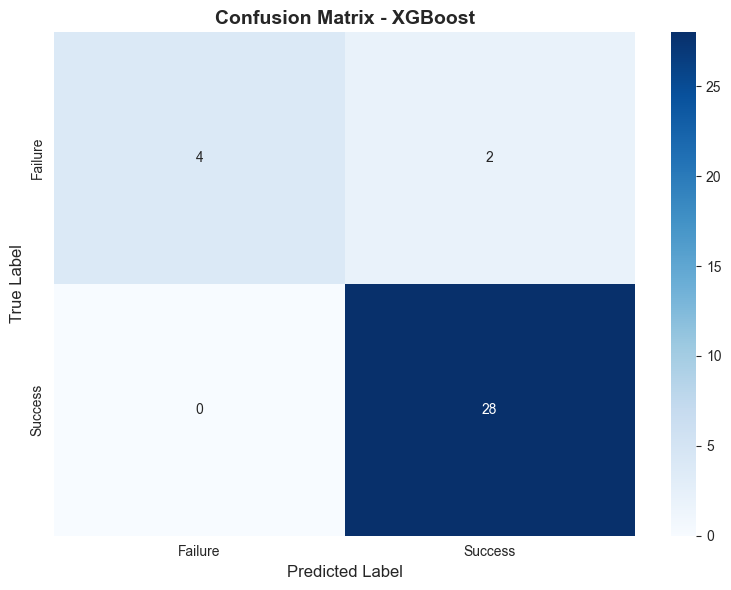

In [8]:
# Confusion matrix for best model
best_model_name = results_df.iloc[0]['Model']
y_pred_best, _ = predictions[best_model_name]

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Best Model Analysis


Best Model: XGBoost

Classification Report:
              precision    recall  f1-score   support

     Failure       1.00      0.67      0.80         6
     Success       0.93      1.00      0.97        28

    accuracy                           0.94        34
   macro avg       0.97      0.83      0.88        34
weighted avg       0.95      0.94      0.94        34


Top 10 Feature Importances:
              Feature  Importance
             GridFins    0.492336
                 Legs    0.248055
         Serial_B1039    0.113161
         Serial_B1059    0.044518
          ReusedCount    0.029783
LaunchSite_KSC LC 39A    0.010299
              Flights    0.009825
           Orbit_VLEO    0.009246
                Block    0.008766
            Orbit_ISS    0.007934


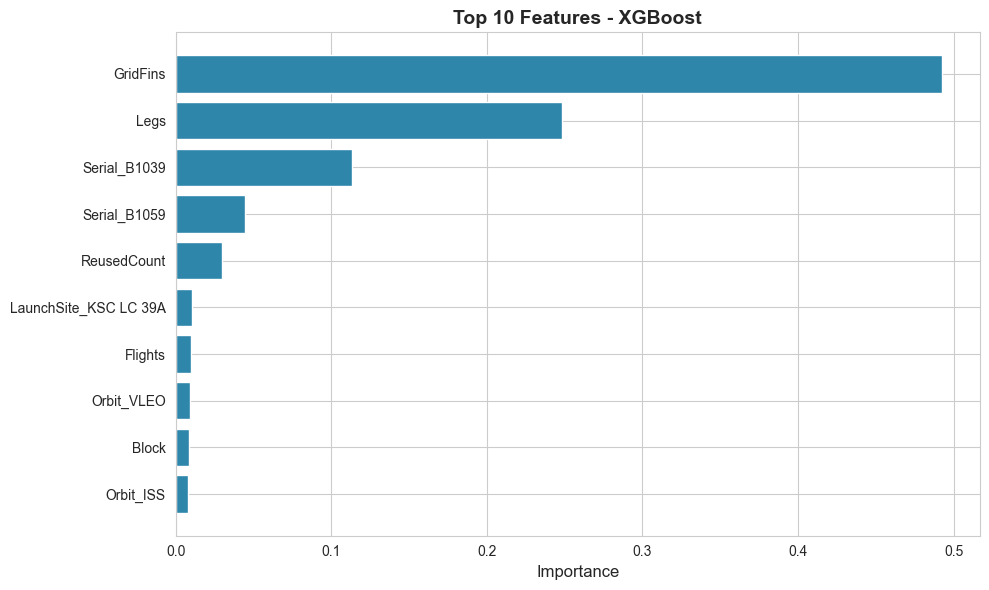

In [9]:
best_model = trained_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Failure', 'Success']))

# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    print("\nTop 10 Feature Importances:")
    print(feature_importance.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='#2E86AB')
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 10 Features - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [10]:
# Save model for deployment
import pickle

model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': df.drop('Class', axis=1).columns.tolist(),
    'model_name': best_model_name,
    'performance': results_df.iloc[0].to_dict()
}

with open('spacex_landing_predictor.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("✓ Model artifacts prepared for deployment")
print(f"  - Best model: {best_model_name}")
print(f"  - Feature scaler included")
print(f"  - {len(model_artifacts['feature_names'])} features")

✓ Model artifacts prepared for deployment
  - Best model: XGBoost
  - Feature scaler included
  - 85 features


## 8. Business Impact: Cost Analysis

In [11]:
SPACEX_REUSABLE = 62_000_000
SPACEX_EXPENDABLE = 90_000_000
COMPETITOR = 165_000_000

def estimate_cost(success_prob):
    """Estimate launch cost based on landing probability"""
    return success_prob * SPACEX_REUSABLE + (1 - success_prob) * SPACEX_EXPENDABLE

# Calculate costs
_, y_proba_best = predictions[best_model_name]
estimated_costs = [estimate_cost(p) for p in y_proba_best]
actual_costs = [SPACEX_REUSABLE if y == 1 else SPACEX_EXPENDABLE for y in y_test]

avg_estimated = np.mean(estimated_costs)
avg_actual = np.mean(actual_costs)
cost_savings = COMPETITOR - avg_actual

print("\nCost Analysis:")
print("="*60)
print(f"Average Estimated Cost: ${avg_estimated:,.0f}")
print(f"Average Actual Cost: ${avg_actual:,.0f}")
print(f"Estimation Error: ${abs(avg_estimated - avg_actual):,.0f}")
print(f"\nSpaceX vs Competitor Savings: ${cost_savings:,.0f}")
print(f"Cost Advantage: {(1 - avg_actual/COMPETITOR)*100:.1f}%")


Cost Analysis:
Average Estimated Cost: $66,711,356
Average Actual Cost: $66,941,176
Estimation Error: $229,820

SpaceX vs Competitor Savings: $98,058,824
Cost Advantage: 59.4%


## 9. Summary

In [12]:
best_metrics = results_df.iloc[0]

print("\n" + "="*80)
print("EXECUTIVE SUMMARY")
print("="*80)

print(f"\n1. BEST MODEL: {best_model_name}")
print(f"   • Accuracy: {best_metrics['Accuracy']:.1%}")
print(f"   • Precision: {best_metrics['Precision']:.1%}")
print(f"   • Recall: {best_metrics['Recall']:.1%}")
print(f"   • F1-Score: {best_metrics['F1-Score']:.1%}")

print(f"\n2. BUSINESS IMPACT")
print(f"   • SpaceX Average Cost: ${avg_actual:,.0f}")
print(f"   • Competitor Cost: ${COMPETITOR:,.0f}")
print(f"   • Cost Savings: ${cost_savings:,.0f} ({(1-avg_actual/COMPETITOR)*100:.1f}%)")

print(f"\n3. KEY FINDINGS")
print(f"   • Model achieves {best_metrics['Accuracy']:.1%} accuracy on test data")
print(f"   • Successfully identifies {best_metrics['Recall']:.1%} of successful landings")
print(f"   • Ready for deployment in competitive bid analysis")

print(f"\n4. RECOMMENDATIONS")
print(f"   • Deploy {best_model_name} for production use")
print(f"   • Use probability scores for risk assessment")
print(f"   • Update model quarterly with new launch data")
print(f"   • Monitor model performance for drift")

print("\n" + "="*80)


EXECUTIVE SUMMARY

1. BEST MODEL: XGBoost
   • Accuracy: 94.1%
   • Precision: 93.3%
   • Recall: 100.0%
   • F1-Score: 96.6%

2. BUSINESS IMPACT
   • SpaceX Average Cost: $66,941,176
   • Competitor Cost: $165,000,000
   • Cost Savings: $98,058,824 (59.4%)

3. KEY FINDINGS
   • Model achieves 94.1% accuracy on test data
   • Successfully identifies 100.0% of successful landings
   • Ready for deployment in competitive bid analysis

4. RECOMMENDATIONS
   • Deploy XGBoost for production use
   • Use probability scores for risk assessment
   • Update model quarterly with new launch data
   • Monitor model performance for drift



---

## References

- **Scikit-learn Documentation**: https://scikit-learn.org/stable/
- **Grid Search CV**: https://scikit-learn.org/stable/modules/grid_search.html
- **Model Evaluation**: https://scikit-learn.org/stable/modules/model_evaluation.html
- **SpaceX Launch Data**: https://www.spacex.com/launches/

---

*Machine Learning Prediction - SpaceX Falcon 9 Landing Success*  
*Analysis Completed: November 2025*  